## Solution 1: HRO in sklearn

In [1]:
# general
import numpy as np
import pandas as pd
import math

# plots
import matplotlib.pyplot as plt
import seaborn as sns

# sklearn
from sklearn.datasets import load_iris
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import LinearRegression
import sklearn.metrics as metrics
from sklearn.metrics import mean_absolute_error

In [2]:
# | label: hro-objects

# H: First, initialize your learner.
# Before training learners just contain information on the functional form of f.
model = LinearRegression(fit_intercept=True)
print(model)
x = np.arange(0, 8, 0.01)
np.random.seed(42)
y = -1 + 3 * x + np.random.normal(loc=0.0, scale=4, size=len(x))
# R: `sklearn` relies on package-specific learning objectives.
# O: Optimization is triggered by `model.fit()`, internally calling
# package-specific optimization procedures.
# within the function `model.fit()`:
model.fit(x.reshape(-1, 1), y)  # reshape for one feature design matrix
mse = metrics.mean_squared_error(y, model.predict(x.reshape(-1, 1)))
print(f"Model MSE: {mse:.4f}")

LinearRegression()
Model MSE: 15.4618


In [3]:
# | label: hro-task

iris = load_iris()  # function to import iris as type "utils.Bunch" with sklearn
X = iris.data
y = iris.target
feature_names = iris.feature_names
target_names = iris.target_names
print("Type of object iris:", type(iris))
print("Feature names:"), [print(f"{i}") for i in feature_names]
print("Target names:", target_names)
print("\nShape of X and y\n", X.shape, y.shape)
print("\nType of X and y\n", type(X), type(y))

Type of object iris: <class 'sklearn.utils._bunch.Bunch'>
Feature names:
sepal length (cm)
sepal width (cm)
petal length (cm)
petal width (cm)
Target names: ['setosa' 'versicolor' 'virginica']

Shape of X and y
 (150, 4) (150,)

Type of X and y
 <class 'numpy.ndarray'> <class 'numpy.ndarray'>


In [1]:
# help(DecisionTreeRegressor)
# Prints documentary in console, or visit scikit-learn.org --> select right version
# --> go to right class, here sklearn.tree.DecisionTreeRegressor.

In [5]:
# | label: hro-learner

# Inspect regression tree learner
rtree = DecisionTreeRegressor()  # default setting
print(rtree)

# List configurable hyperparameters
[print(f"{k}: {v}") for k, v in rtree.get_params().items()][0]

DecisionTreeRegressor()
ccp_alpha: 0.0
criterion: squared_error
max_depth: None
max_features: None
max_leaf_nodes: None
min_impurity_decrease: 0.0
min_samples_leaf: 1
min_samples_split: 2
min_weight_fraction_leaf: 0.0
random_state: None
splitter: best


The empirical risk is:

$$
\mathcal{R}_{emp}(\mathbf{\theta})= \sum_{i=1}^{50} \left( y^{(i)} - \left[ \theta_0 + \theta_1 x^{(i)} + \theta_2 \left(x^{(i)}\right)^2 + \theta_3 \left(x^{(i)}\right)^3 \right] \right)^2
$$

We can find the gradient just as we did for an intermediate result when we derived the least-squares estimator:
$$
\nabla_{\mathbf{\theta}} \mathcal{R}_{emp}(\mathbf{\theta}) = \frac{\partial}{\partial \mathbf{\theta}} \left \| \mathbf{y} - \mathbf{X}\mathbf{\theta} \right \|_2^2\\
= \frac{\partial}{\partial \mathbf{\theta}} \left( (\mathbf{y} - \mathbf{X}\mathbf{\theta})^\top (\mathbf{y} - \mathbf{X}\mathbf{\theta})\right)\\
= -2 \mathbf{y}^\top \mathbf{X}  + 2 \mathbf{\theta}^\top \mathbf{X}^\top \mathbf{X} \\
= 2 \cdot \left( -\mathbf{y}^\top \mathbf{X} + \mathbf{\theta}^\top \mathbf{X}^\top \mathbf{X} \right)
$$

Recall that the idea of gradient descent (*descent!*) is to traverse the risk surface in the direction of the negative
gradient as we are in search for the minimum. Therefore, we will update our current parameter set $\mathbf{\theta}^{[t]}$ with
the negative gradient of the current empirical risk w.r.t. $\mathbf{\theta}$, scaled by learning rate (or step size) $\alpha$:
$$
\mathbf{\theta}^{[t+1]} = \mathbf{\theta}^{[t]} - \alpha \cdot \nabla_{\mathbf{\theta}} \mathcal{R}_{emp}(\mathbf{\theta}^{[t]}) 
$$

What actually happens here: we update each component of our current parameter vector $\mathbf{\theta}^{[t]}$
in the *direction* of the negative gradient, i.e., following the steepest downward slope, and also by an *amount* that depends on the value of the gradient.


In order to see what that means it is helpful to recall that the gradient $\nabla_{\mathbf{\theta}} \mathcal{R}_{emp}(\mathbf{\theta})$ tells us about the effect (infinitesimally small) changes in $\mathbf{\theta}$ have on $\mathcal{R}_{emp}(\mathbf{\theta})$. A parameter vector component with large gradient has strong impact on the empirical risk, and it is reasonable to assume it to be rather important for the model. <br>
Therefore, gradient updates focus on influential components, and we proceed more quickly along the important
dimensions.

## Solution 4: Predicting abalone

In [11]:
# | label: abalone-data
# load data from url

url = "https://archive.ics.uci.edu/ml/machine-learning-databases/abalone/abalone.data"
abalone = pd.read_csv(
    url,
    sep=",",
    names=[
        "sex",
        "longest_shell",
        "diameter",
        "height",
        "whole_weight",
        "shucked_weight",
        "visceral_weight",
        "shell_weight",
        "rings",
    ],
)

abalone = abalone[["longest_shell", "whole_weight", "rings"]]
print(abalone.head)

<bound method NDFrame.head of       longest_shell  whole_weight  rings
0             0.455        0.5140     15
1             0.350        0.2255      7
2             0.530        0.6770      9
3             0.440        0.5160     10
4             0.330        0.2050      7
...             ...           ...    ...
4172          0.565        0.8870     11
4173          0.590        0.9660     10
4174          0.600        1.1760      9
4175          0.625        1.0945     10
4176          0.710        1.9485     12

[4177 rows x 3 columns]>


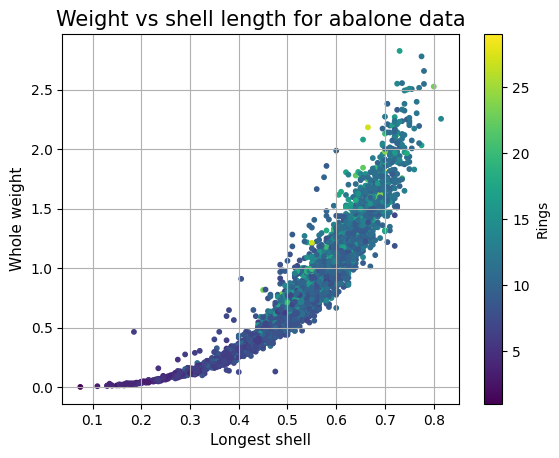

In [12]:
# | label: abalone-plot
plt.grid(True)
plt.scatter(
    abalone.longest_shell, abalone.whole_weight, s=10, c=abalone.rings, cmap="viridis"
)
plt.colorbar(label="Rings")  # add color bar
# title & label axes
plt.title("Weight vs shell length for abalone data", size=15)
plt.xlabel("Longest shell", size=11)
plt.ylabel("Whole weight", size=11)
plt.show()

In [13]:
# | label: abalone-predict

x_lm = abalone.iloc[:, 0:2].values
y_lm = abalone.rings
lm = LinearRegression().fit(x_lm, y_lm)
pred_lm = lm.predict(x_lm)
results_dic = {"prediction": pred_lm, "truth": y_lm}
results = pd.DataFrame(results_dic)
results.head()

,prediction,truth
0,8.840042,15
1,7.395659,7
2,9.821995,9
3,8.683616,10
4,7.160333,7


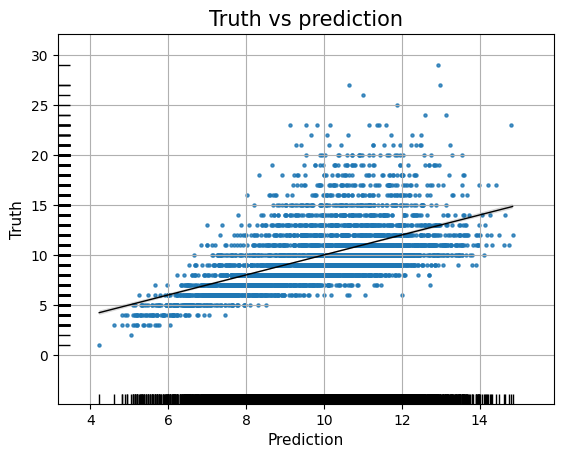

In [14]:
# | label: abalone-viz
plt.grid(True)
sns.regplot(
    x=pred_lm,
    y=y_lm,
    ci=95,
    scatter_kws={"s": 5},
    line_kws={"color": "black", "linewidth": 1},
)
sns.rugplot(x=pred_lm, y=y_lm, height=0.025, color="k")
# title & label axes
plt.title("Truth vs prediction", size=15)
plt.xlabel("Prediction", size=11)
plt.ylabel("Truth", size=11)
plt.show()

In [15]:
# | label: abalone-eval

mae = mean_absolute_error(pred_lm, y_lm)
print(f"{mae:.4f}")

1.9507


### *)  Additional model assessing

There exists no `R`-type regression summary report in `sklearn`. The main reason is that sklearn is used for predictive modeling / machine learning and the evaluation criteria are based on performance on previously unseen data.
For the statistical view on linear regression you can use the package `statsmodels`:

In [16]:
import statsmodels.formula.api as smf

The function OLS performs ordinary-least-squares linear regression and has a `summary()` function. 

In [17]:
stats_lm = smf.ols("rings ~ longest_shell + whole_weight", data=abalone).fit()
stats_lm.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  rings   R-squared:                       0.314
Model:                            OLS   Adj. R-squared:                  0.314
Method:                 Least Squares   F-statistic:                     956.9
Date:                Thu, 02 May 2024   Prob (F-statistic):               0.00
Time:                        13:08:05   Log-Likelihood:                -10028.
No. Observations:                4177   AIC:                         2.006e+04
Df Residuals:                    4174   BIC:                         2.008e+04
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept         3.4313      0.316     10.873      0.000       2.813       4.050
longest_shell    10.5824      0.907     11.666      0.000       8.804      12.361
whole_weight      1.1550      0.222      5.200      0.000       0.720       1.591
==============================================================================
Omnibus:                     1380.300   Durbin-Watson:                   0.943
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             4440.751
Skew:                           1.687   Prob(JB):                         0.00
Kurtosis:                       6.759   Cond. No.                         34.2
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In the summary function you can retrieve very easily the fitted coefficients and various model metrics based on the model itself and the training data.

Nevertheless, self-defined functions can be used for assessing models from sklearn:

In [18]:
def regression_results(y_true, y_pred):
    """
    Method to produce model metrics for training data
    Input: training response vector as array, prediction vector as array
    Output: -
    """
    # Regression metrics
    explained_variance = metrics.explained_variance_score(y_true, y_pred)
    mean_absolute_error = metrics.mean_absolute_error(y_true, y_pred)
    mse = metrics.mean_squared_error(y_true, y_pred)
    mean_squared_log_error = metrics.mean_squared_log_error(y_true, y_pred)
    median_absolute_error = metrics.median_absolute_error(y_true, y_pred)
    r2 = metrics.r2_score(y_true, y_pred)

    print("explained_variance: ", round(explained_variance, 4))
    print("mean_squared_log_error: ", round(mean_squared_log_error, 4))
    print("r2: ", round(r2, 4))
    print("MAE: ", round(mean_absolute_error, 4))
    print("MSE: ", round(mse, 4))
    print("RMSE: ", round(np.sqrt(mse), 4))
    print("Median Absolut Error: ", round(median_absolute_error, 4))

In [19]:
regression_results(y_lm, pred_lm)

explained_variance:  0.3144
mean_squared_log_error:  0.0471
r2:  0.3144
MAE:  1.9507
MSE:  7.1255
RMSE:  2.6694
Median Absolut Error:  1.5254
